In [5]:
import os
import pandas as pd


save_root = '/home/ddon0001/PhD/experiments/sampling_pred/'
root_pth = '/home/ddon0001/PhD/experiments/scaled/no_div_constraint/'
ds_summary_path = os.path.join(root_pth, 'summary.csv')
ds_info = pd.read_csv(ds_summary_path)[['ds_name', 'det_path']]

# overall_df = pd.read_csv(os.path.join(save_root, 'overall.csv'))
# plot_order = overall_df[overall_df.sol_incorrect].ds_name.value_counts().index

In [7]:
import json
import networkx as nx    

dfs = []
for i, row in ds_info.iterrows():
    ds_name = row['ds_name']
    pth = os.path.join(save_root, ds_name + '.csv')
    if not os.path.exists(pth):
        continue
    pred_csv = pd.read_csv(pth)
    eoi = pred_csv
    eoi['ds_name'] = ds_name
    eoi['solution_correct'] = (eoi.flow > 0) == (eoi.oracle_is_correct)
    eoi['sol_incorrect'] = eoi['solution_correct'] == False
    eoi['classifier_correct'] = (eoi.classifier_pred) == (eoi.oracle_is_correct)

    gt_solution = nx.read_graphml(os.path.join(root_pth, ds_name, 'matched_gt.graphml'))
    with open(os.path.join(root_pth, ds_name, 'matching.json'), 'r') as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}

    def is_div_involved(row):
        if row['u'] in sol_to_gt and row['v'] in sol_to_gt:
            u = sol_to_gt[row['u']]
            v = sol_to_gt[row['v']]
            return gt_solution.out_degree(u) > 1
        return False
        
    eoi['div_involved'] = eoi.apply(is_div_involved, axis=1)

    dfs.append(eoi)
overall_df = pd.concat(dfs, axis=0)
print(len(overall_df))
print(overall_df.columns)

2940574
Index(['Unnamed: 0', 'u', 'v', 'flow', 'oracle_is_correct', 'classifier_pred',
       'classifier_prob_correct', 'test_set', 'distance',
       'chosen_neighbour_area_prop', 'chosen_neighbour_rank', 'ds_name',
       'solution_correct', 'sol_incorrect', 'classifier_correct',
       'div_involved'],
      dtype='object')


In [8]:
overall_df.to_csv(os.path.join(save_root, 'overall.csv'), index=False)

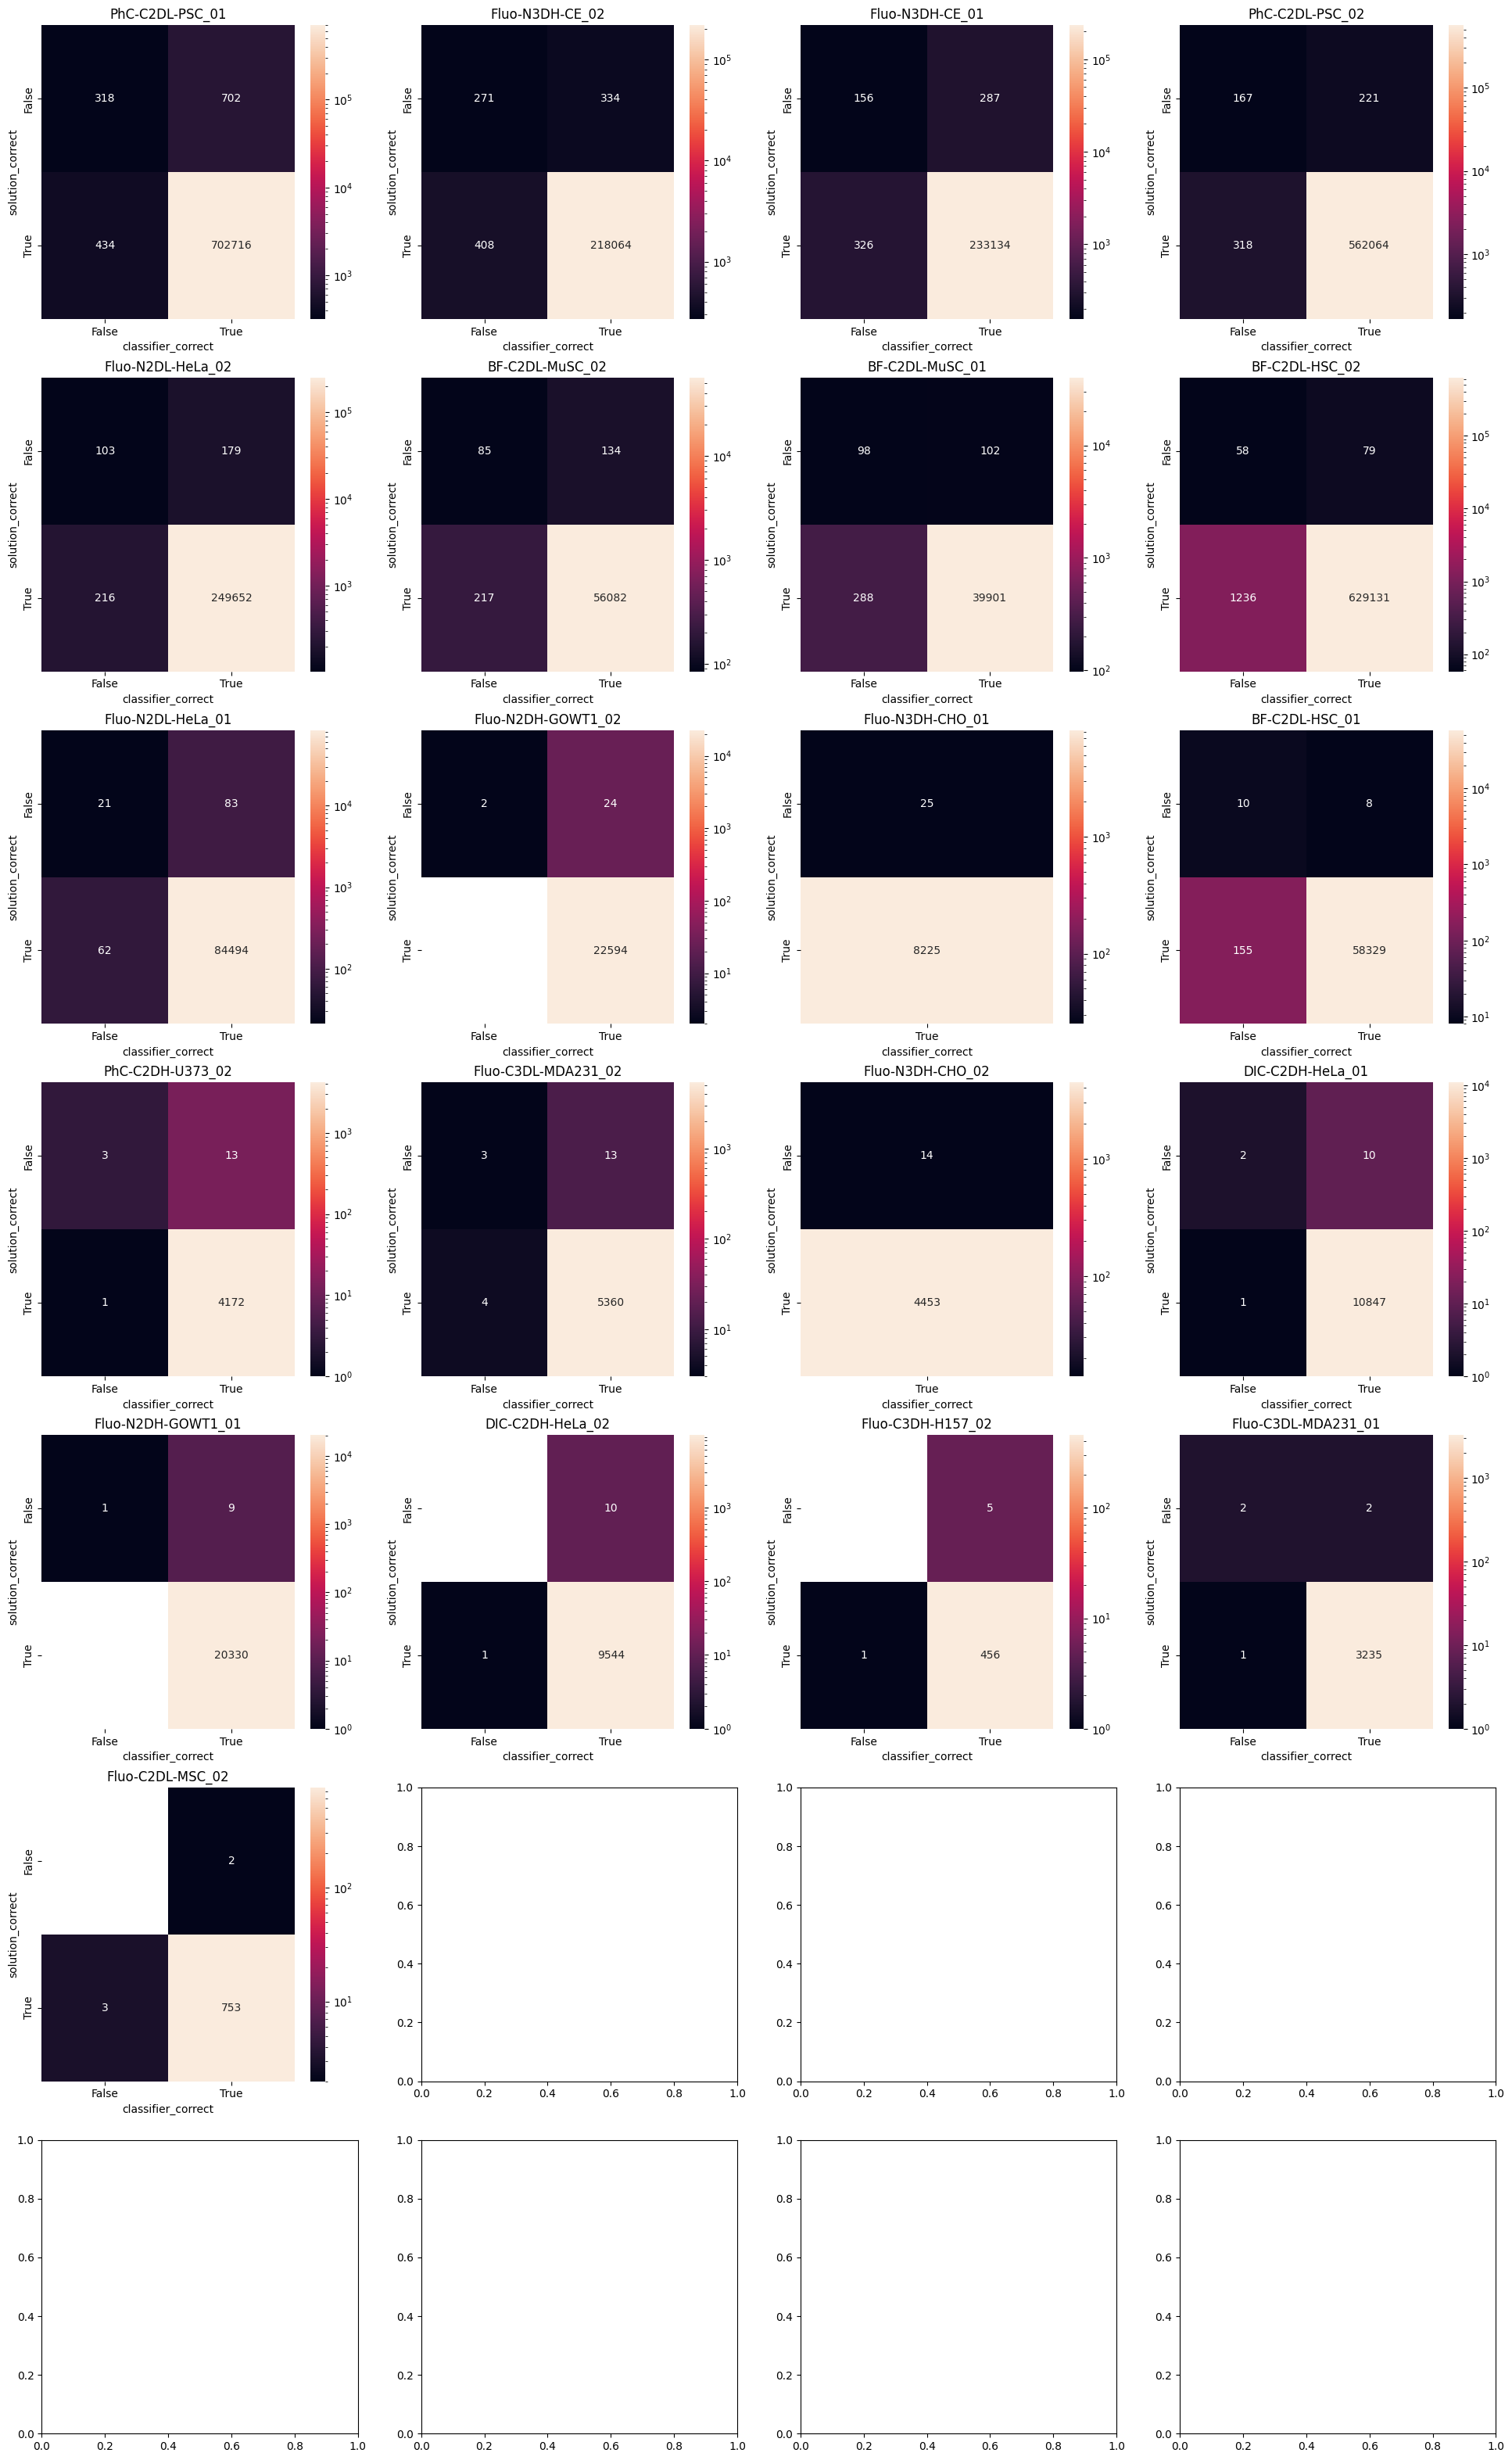

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

plot_order = overall_df[overall_df.sol_incorrect].ds_name.value_counts().index

fig, axs = plt.subplots(figsize=(24,40), nrows=7, ncols=4)
targets = zip(plot_order, axs.flatten())

def get_heatmap(data, **kwargs):
    data = pd.crosstab(data['solution_correct'], data['classifier_correct'])
    sns.heatmap(data, annot=True, fmt='g', norm=LogNorm(), **kwargs)

for i, (key, ax) in enumerate(targets):
    data = overall_df[overall_df.ds_name == key]
    get_heatmap(data, ax=ax)
    ax.set_title(key)
plt.show()

In [5]:
# Precision/recall curve for our classifier correct vs. solution correct matrices

# precision: of the edges where the classifier and model disagree, how often is the classifier right
# recall: of the edges where the model is wrong, how many edges is the classifier fixing

import numpy as np


thresholds = np.arange(0, 1.04, 0.05)

for threshold in thresholds:
    # for each dataset
    # compute the new columns of classifier_pred based on classifier_prob_correct
    overall_df[f'classifier_pred_{threshold}'] = overall_df['classifier_prob_correct'] > threshold
    # compute new column classifier_correct using classifier_pred and oracle_is_correct
    overall_df[f'classifier_correct_{threshold}'] = overall_df[f'classifier_pred_{threshold}'] == overall_df['oracle_is_correct']


ds_names = []
prob_thresholds = []
precisions = []
recalls = []
in_sol = []
for threshold in thresholds:
    for ds_name in plot_order:
        ds_data = overall_df[overall_df.ds_name == ds_name]
        edges_in_sol = ds_data[ds_data.flow > 0]
        edges_not_in_sol = ds_data[ds_data.flow == 0]
        for i, data in enumerate([edges_in_sol, edges_not_in_sol]):
            classifier_correct = data[f'classifier_correct_{threshold}']
            solution_correct = data['solution_correct']
            ct = pd.crosstab(solution_correct, classifier_correct, dropna=False)

            try:
                both_correct = ct.loc[True, True]
            except KeyError:
                both_correct = 0
            
            try: 
                cls_wrong_model_correct = ct.loc[True, False]
            except KeyError:
                cls_wrong_model_correct = 0

            try:
                both_wrong = ct.loc[False, False]
            except KeyError:
                both_wrong = 0

            try:
                model_wrong_cls_correct = ct.loc[False, True]
            except KeyError:
                model_wrong_cls_correct = 0

            model_cls_disagree = model_wrong_cls_correct + cls_wrong_model_correct
            precision = 0 if model_cls_disagree == 0 else model_wrong_cls_correct / model_cls_disagree

            model_wrong = model_wrong_cls_correct + both_wrong
            recall = 0 if model_wrong == 0 else model_wrong_cls_correct / model_wrong

            ds_names.append(ds_name)
            prob_thresholds.append(threshold)
            precisions.append(precision)
            recalls.append(recall)
            if i == 0:
                in_sol.append(True)
            else:
                in_sol.append(False)
prec_recall_df = pd.DataFrame({
    'ds_name': ds_names,
    'threshold': prob_thresholds,
    'precision': precisions,
    'recall': recalls,
    'in_sol': in_sol
})
prec_recall_df


,ds_name,threshold,precision,recall,in_sol
0,PhC-C2DL-PSC_01,0.0,0.000000,0.0,True
1,PhC-C2DL-PSC_01,0.0,0.000299,1.0,False
2,Fluo-N3DH-CE_02,0.0,0.000000,0.0,True
3,Fluo-N3DH-CE_02,0.0,0.001732,1.0,False
4,Fluo-N3DH-CE_01,0.0,0.000000,0.0,True
...,...,...,...,...,...
877,Fluo-C3DH-H157_02,1.0,0.000000,0.0,False
878,Fluo-C3DL-MDA231_01,1.0,0.009464,1.0,True
879,Fluo-C3DL-MDA231_01,1.0,0.000000,0.0,False
880,Fluo-C2DL-MSC_02,1.0,0.000000,0.0,True


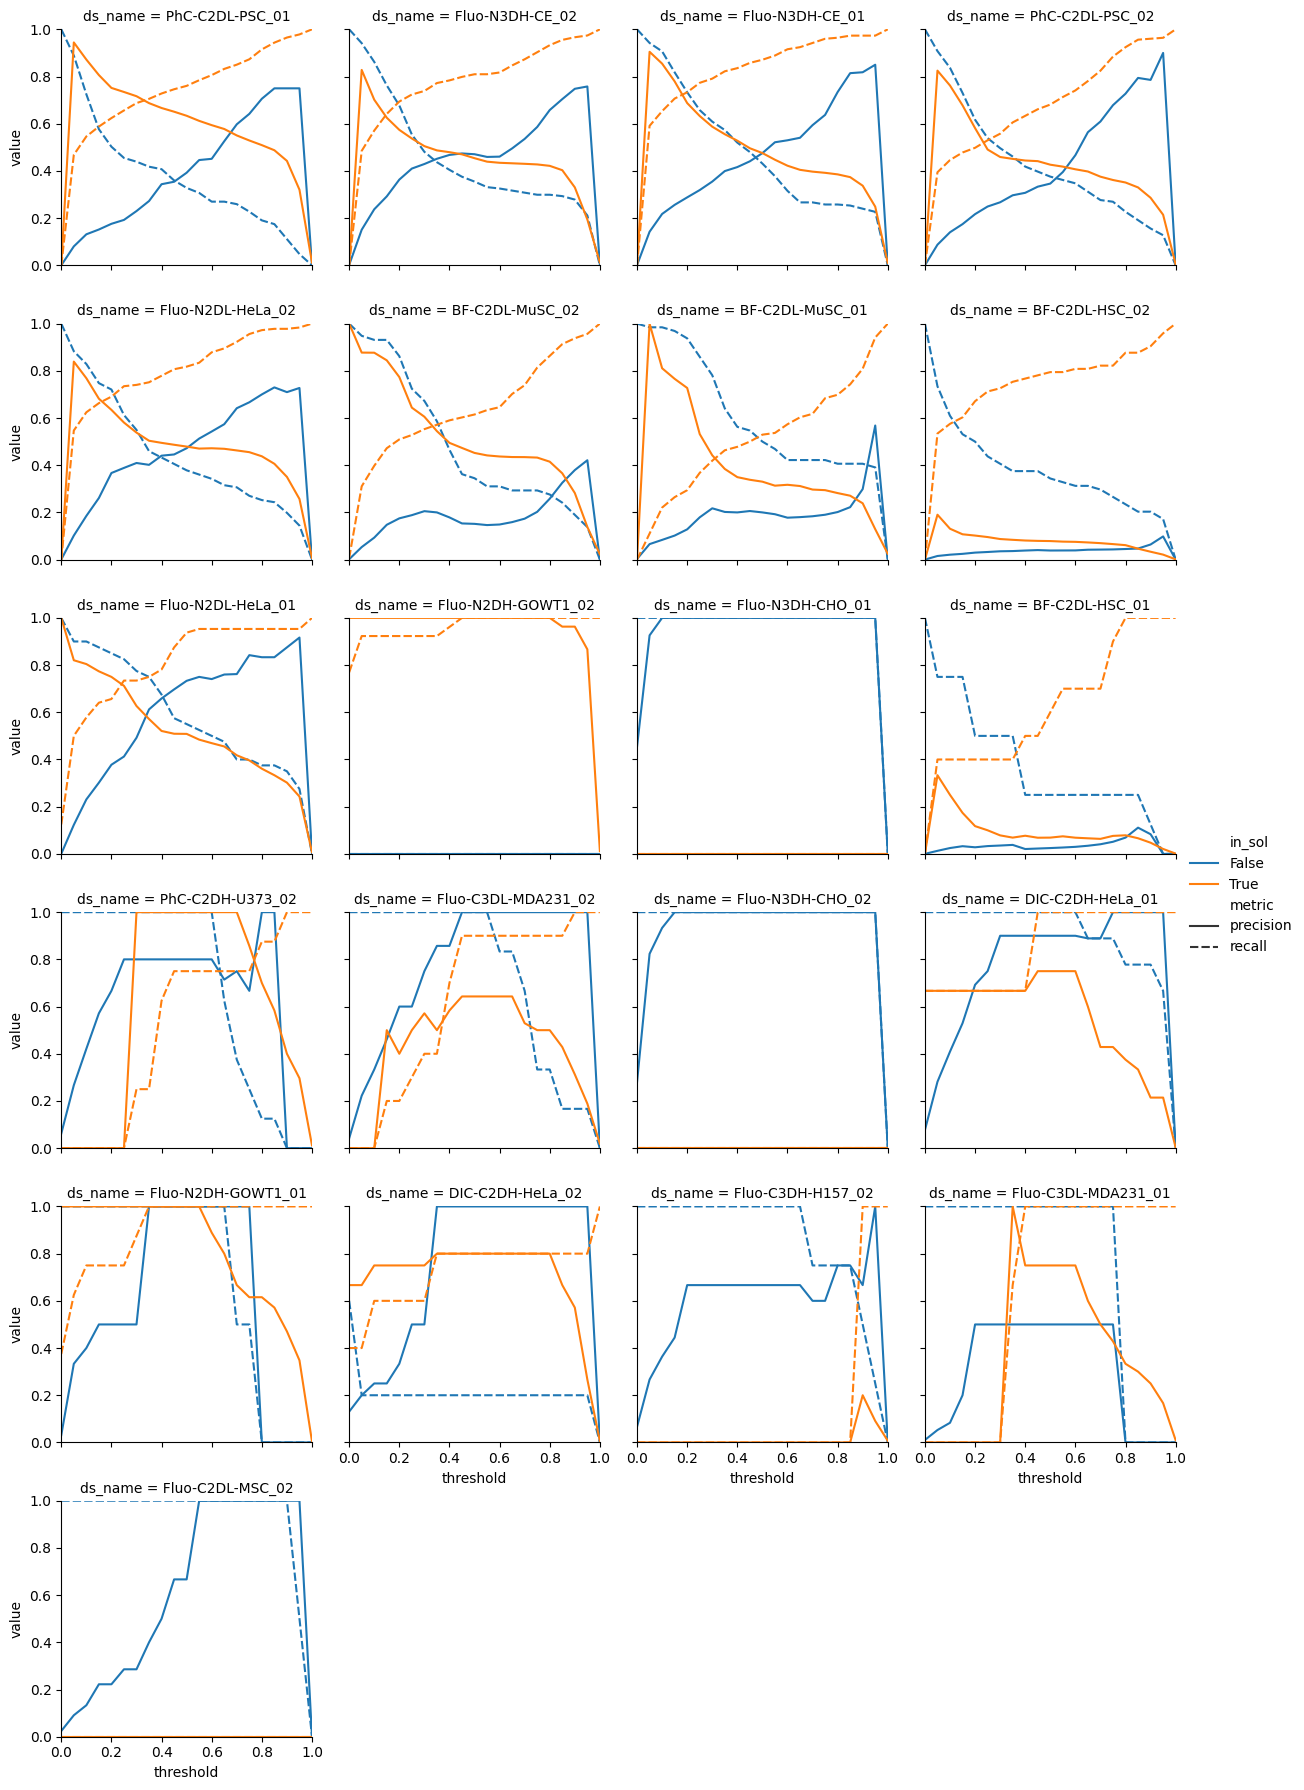

In [8]:
import seaborn as sns

prec_recall_melt = prec_recall_df.melt(id_vars=['ds_name', 'threshold', 'in_sol'], value_vars=['precision', 'recall'], var_name='metric')

grid = sns.FacetGrid(prec_recall_melt, col='ds_name', col_wrap=4, sharex=True, col_order=plot_order, xlim=(0,1), ylim=(0,1), sharey=True)
grid.map_dataframe(sns.lineplot, x='threshold', y='value', estimator=None, errorbar=None, hue='in_sol', style='metric')
grid.add_legend()

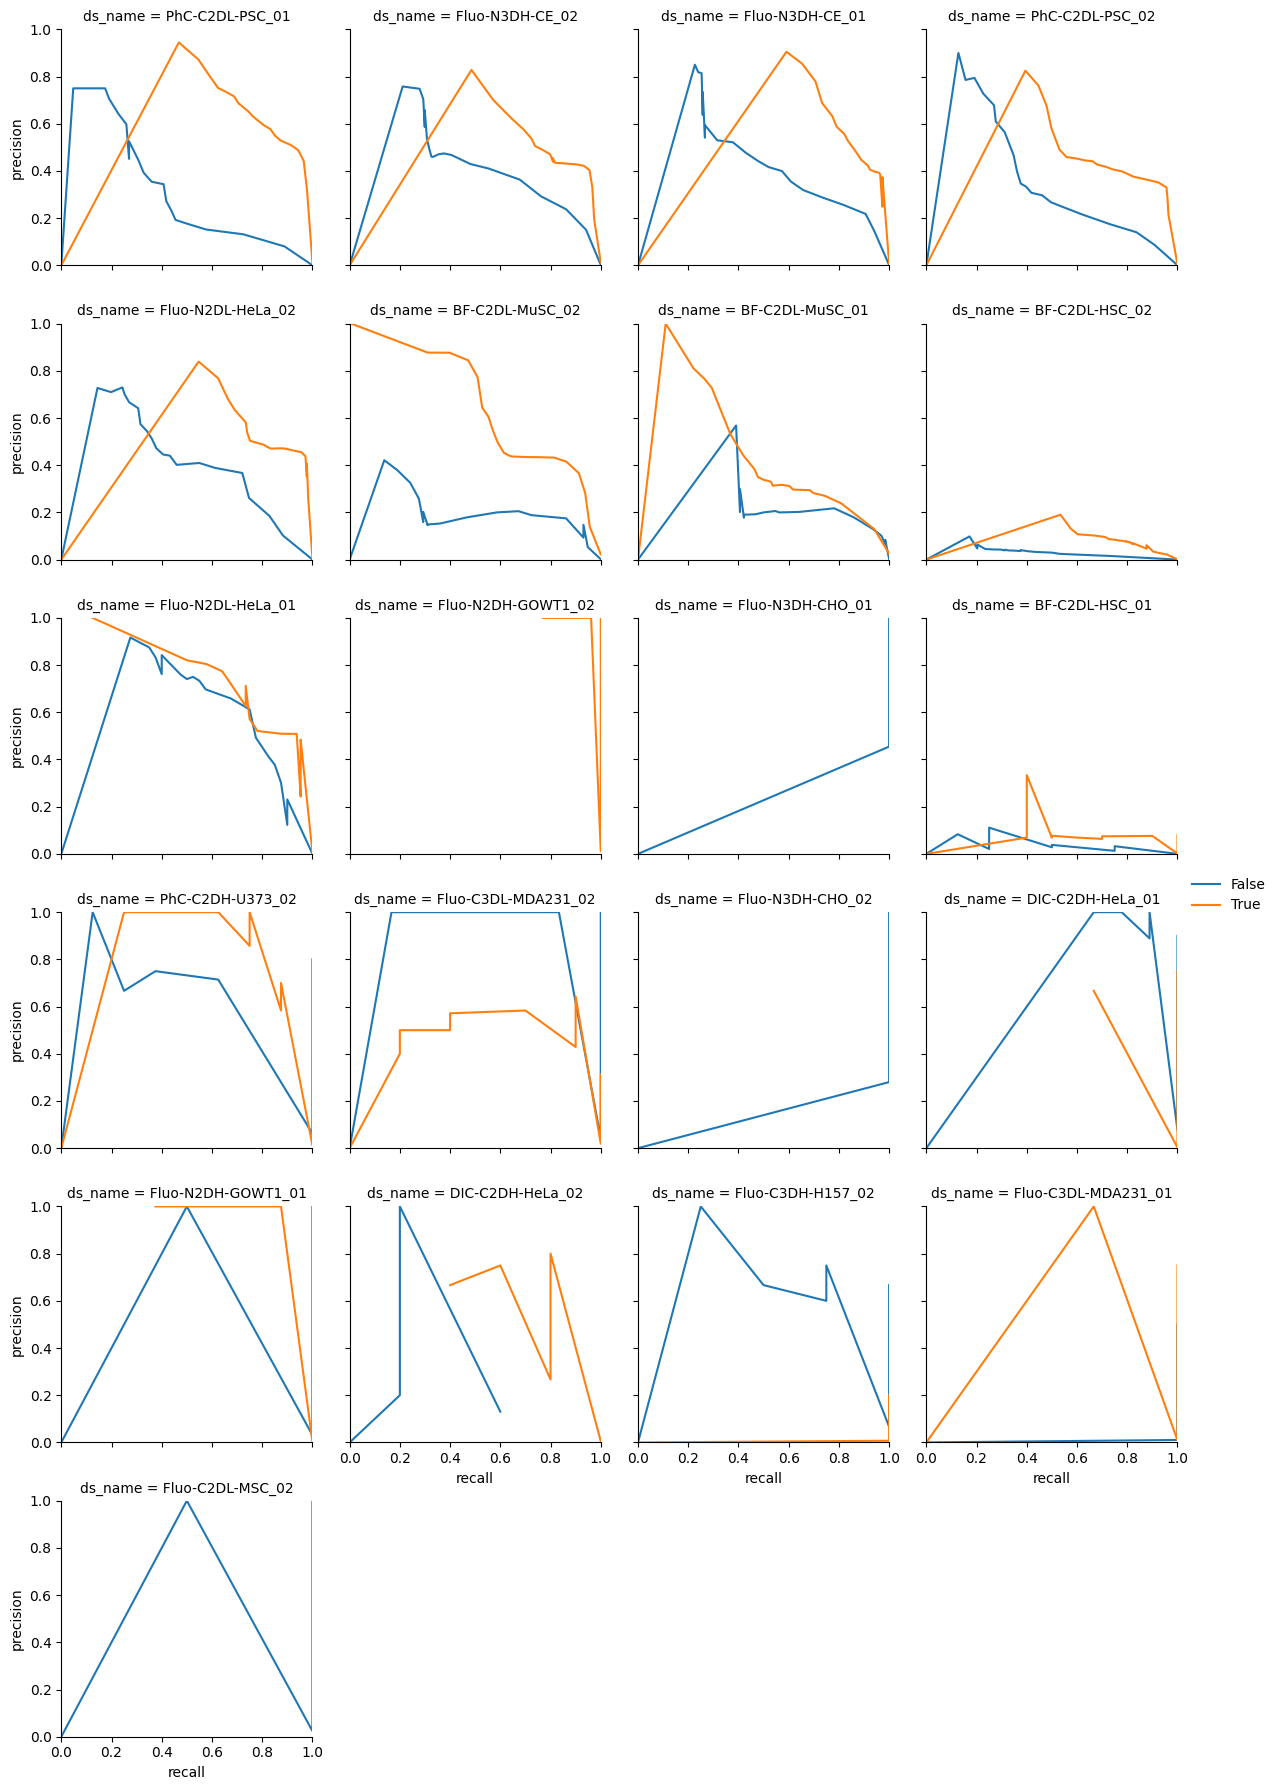

In [9]:
import seaborn as sns

grid = sns.FacetGrid(prec_recall_df, col='ds_name', col_wrap=4, sharex=True, col_order=plot_order, xlim=(0,1), ylim=(0,1), sharey=True)
grid.map_dataframe(sns.lineplot, x='recall', y='precision', estimator=None, errorbar=None, hue='in_sol')
grid.add_legend()

In [13]:
ds_names = []
chance_in_sol = []
chance_not_in_sol = []
for ds_name in plot_order:
    ds_data = overall_df[overall_df.ds_name == ds_name]
    edges_in_sol = ds_data[ds_data.flow > 0]
    edges_not_in_sol = ds_data[ds_data.flow == 0]

    total_in_sol = len(edges_in_sol)
    total_not_in_sol = len(edges_not_in_sol)

    chance_level_in_sol = edges_in_sol['sol_incorrect'].sum() / total_in_sol
    chance_level_not_in_sol = edges_not_in_sol['sol_incorrect'].sum() / total_not_in_sol
    
    ds_names.append(ds_name)
    chance_in_sol.append(chance_level_in_sol)
    chance_not_in_sol.append(chance_level_not_in_sol)
chance_df = pd.DataFrame({
    'ds_name': ds_names,
    'chance_in_sol': chance_in_sol,
    'chance_not_in_sol': chance_not_in_sol
})
print(chance_df)

                ds_name  chance_in_sol  chance_not_in_sol
0       PhC-C2DL-PSC_01       0.011719           0.000299
1       Fluo-N3DH-CE_02       0.012074           0.001732
2       Fluo-N3DH-CE_01       0.009469           0.001071
3       PhC-C2DL-PSC_02       0.004427           0.000279
4     Fluo-N2DL-HeLa_02       0.007190           0.000493
5       BF-C2DL-MuSC_02       0.022158           0.001178
6       BF-C2DL-MuSC_01       0.025092           0.001830
7        BF-C2DL-HSC_02       0.001132           0.000113
8     Fluo-N2DL-HeLa_01       0.007492           0.000525
9    Fluo-N2DH-GOWT1_02       0.011469           0.000000
10     Fluo-N3DH-CHO_01       0.000000           0.003380
11       BF-C2DL-HSC_01       0.001153           0.000161
12     PhC-C2DH-U373_02       0.011765           0.002280
13  Fluo-C3DL-MDA231_02       0.018904           0.001237
14     Fluo-N3DH-CHO_02       0.000000           0.003598
15     DIC-C2DH-HeLa_01       0.002799           0.000919
16   Fluo-N2DH

In [ ]:
only_new_errors = overall_df[(overall_df['classifier_correct'] == False) & (overall_df['solution_correct'] == True) & (overall_df['test_set'])]

import seaborn as sns

grid = sns.FacetGrid(only_new_errors, col='ds_name', col_wrap=4, sharex=True, col_order=plot_order, xlim=(0,1), sharey=False, hue='oracle_is_correct')
grid.map_dataframe(sns.histplot, x='classifier_prob_correct')
grid.add_legend()

In [ ]:
only_new_errors = overall_df[(overall_df['classifier_correct'] == False) & (overall_df['solution_correct'] == True)]

import seaborn as sns

grid = sns.FacetGrid(only_new_errors, col='ds_name', col_wrap=4, sharex=True, col_order=plot_order, xlim=(0,1), sharey=False, hue='div_involved')
grid.map_dataframe(sns.histplot, x='classifier_prob_correct')
grid.add_legend()